A notebook for the development of initial GNLDR models

In [1]:
%load_ext autoreload
%autoreload 2

In [133]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import Identity

from janelia_core.math.basic_functions import optimal_orthonormal_transform
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import PWLNNFcn
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices
from janelia_core.ml.utils import torch_mod_to_fcn
from janelia_core.visualization.image_generation import generate_2d_fcn_image
from janelia_core.visualization.matrix_visualization import cmp_n_mats

from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import align_intermediate_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import compare_mean_and_lm_dists
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import GNLDRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_simple_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection
from probabilistic_model_synthesis.math import MeanFcnTransformer
from probabilistic_model_synthesis.math import StdFcnTransformer
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts
from probabilistic_model_synthesis.visualization import plot_torch_dist

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# Number of individuals we simulate observing data from 
n_individuals = 5

# Range of the number of variables we observe from each individual - the actual number of variables we observe from an
# individual will be pulled uniformly from this range (inclusive)
n_var_range = [100, 120]

# Range of the numbe0 of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [10000, 15000]

# Number of latent variables in the model
n_latent_vars = 2

# True if we should use GPUs for fitting if they are available
use_gpus = True

# Parameters for the true scales
s_mn = 1.0
s_std = .0001

# Parameters for generating shared m-module we use for fitting
m_n_layers = 5 #2
m_growth_rate = 5 #2
n_intermediate_latent_vars = 3 #3

In [5]:
## Determine which devices we use for fitting

In [6]:
if use_gpus:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

No GPUs found.


## Create the true prior distributions that relate parameters in the model to variable (e.g., neuron) properties

In [7]:
m_true = QuadSurf(torch.tensor([.5, .5]), torch.tensor([.2, -.2]))

In [9]:
true_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=n_intermediate_latent_vars,
                                                  hc_params = {'n_divisions_per_dim': [10, 10], 
                                                               'dim_ranges': np.asarray([[-.1, 1.1], 
                                                                                         [-.1, 1.1]]),
                                                               'n_div_per_hc_side_per_dim': [1, 1]},
                                                  psi_rate_vl_init=1,
                                               s_mn=s_mn, s_std=s_std)

for d in range(n_intermediate_latent_vars):
    true_priors.lm_prior.dists[d].mn_f.b_m.data[:] = torch.randn(true_priors.lm_prior.dists[d].mn_f.b_m.data.shape)
    true_priors.mn_prior.mn_f.b_m.data[:] = 1*torch.randn(true_priors.mn_prior.mn_f.b_m.data.shape)

## Generate properties

In [10]:
ind_n_vars = np.random.randint(n_var_range[0], n_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true models

In [11]:
with torch.no_grad():
    ind_true_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m = m_true,
                              lm=true_priors.lm_prior.form_standard_sample(true_priors.lm_prior.sample(props)), 
                              mn=true_priors.mn_prior.sample(props).squeeze(), 
                              psi=(true_priors.psi_prior.sample(props).squeeze()), 
                              s=true_priors.s_prior.sample(props).squeeze())
                        for props in ind_props]

## Generate data from each model

In [12]:
with torch.no_grad():
    ind_data = [mdl.sample(n_smps) for n_smps, mdl in zip(ind_n_smps, ind_true_mdls)]

## Setup everything for fitting sp models

In [13]:
sp_m_fit = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, 
                                         d_in=n_latent_vars, 
                                         n_layers=m_n_layers, 
                                         growth_rate=m_growth_rate, 
                                         bias=True), 
                             torch.nn.Linear(in_features=n_latent_vars+m_n_layers*m_growth_rate, 
                                             out_features=n_intermediate_latent_vars, 
                                             bias=True))


In [14]:
  sp_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=n_intermediate_latent_vars,
                                                  hc_params = {'n_divisions_per_dim': [10, 10], 
                                                               'dim_ranges': np.asarray([[-.1, 1.1], 
                                                                                         [-.1, 1.1]]),
                                                               'n_div_per_hc_side_per_dim': [1, 1]},
                                               s_mn=s_mn, s_std=s_std)
    
sp_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars, 
                                          n_intermediate_latent_vars=n_intermediate_latent_vars,
                                           s_opts={'mn_mn': 1.0, 'mn_std': .00000001, 'std_iv': .0001})

sp_fit_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m=sp_m_fit, lm=None, mn=None, psi=None, s=None) 
               for i in range(n_individuals)]
                    
                                    
sp_vi_collections = [VICollection(data=ind_data[s_i][1], 
                                  props=ind_props[s_i],
                                  mdl = sp_fit_mdls[s_i],
                                  posteriors = sp_posteriors[s_i]) for s_i in range(n_individuals)]

for vi_coll in sp_vi_collections:
    vi_coll.posteriors.lm_post = sp_priors.lm_prior
    vi_coll.posteriors.mn_post = sp_priors.mn_prior

## Fit the sp models

In [15]:
sp_fitter = Fitter(vi_collections=sp_vi_collections, priors=sp_priors, devices=devices)

In [16]:
sp_fitter.distribute(distribute_data=True, devices=devices)
sp_logs = [sp_fitter.fit(200, milestones=[100], update_int=100, init_lr=.1) for fit_r in range(1)]


=========== EPOCH 0 COMPLETE ===========
Obj: 2.01e+08
----------------------------------------
NELL: 9.36e+06, 1.14e+07, 1.25e+07, 1.34e+07, 1.23e+07
Latent KL: 2.49e+02, 2.84e+02, 2.96e+02, 3.10e+02, 2.89e+02
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 3.01e+01, 3.20e+01, 3.03e+01, 3.17e+01, 3.31e+01
S KL: 2.73e+07, 2.90e+07, 2.75e+07, 2.88e+07, 3.00e+07
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.27942395210266113
----------------------------------------
CPU cur memory used (GB): 3.12e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 2.00e+07
----------------------------------------
NELL: 3.29e+06, 4.00e+06, 3.98e+06, 4.39e+06, 4.22e+06
Latent KL: 1.54e+04, 1.97e+04, 2.22e+04, 1.95e+04, 2.05e+04
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 9.10e+01, 1.17e+02, 6.92e+01, 9.14e+01, 9.85e+01
S KL: 9.54e-02,

## Examine logs of sp fitting performance

<IPython.core.display.Javascript object>


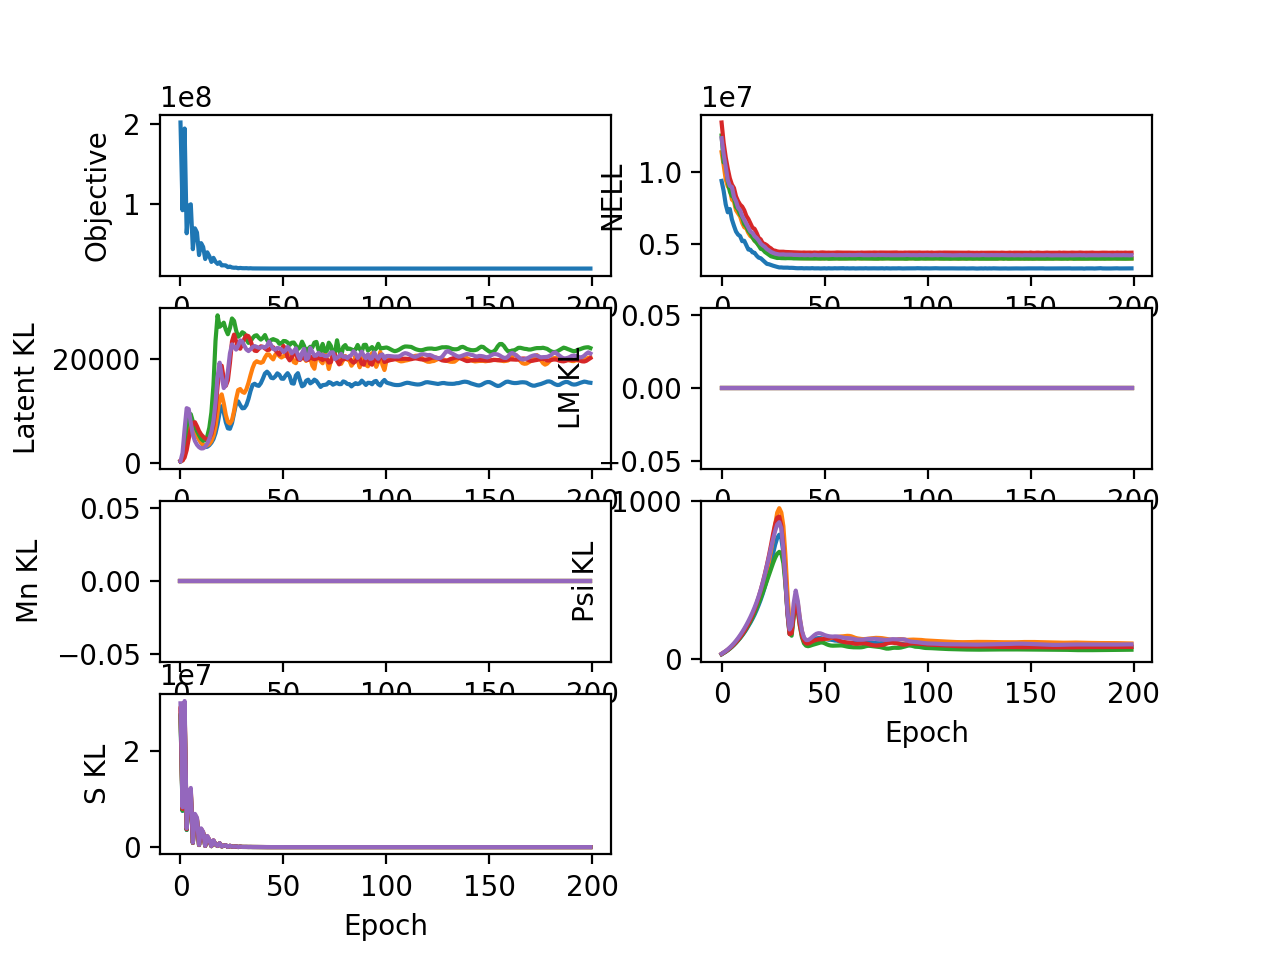

In [17]:
for log in sp_logs:
    sp_fitter.plot_log(log)

## Look at sp model fits

In [18]:
exam_mdl = 0

<IPython.core.display.Javascript object>


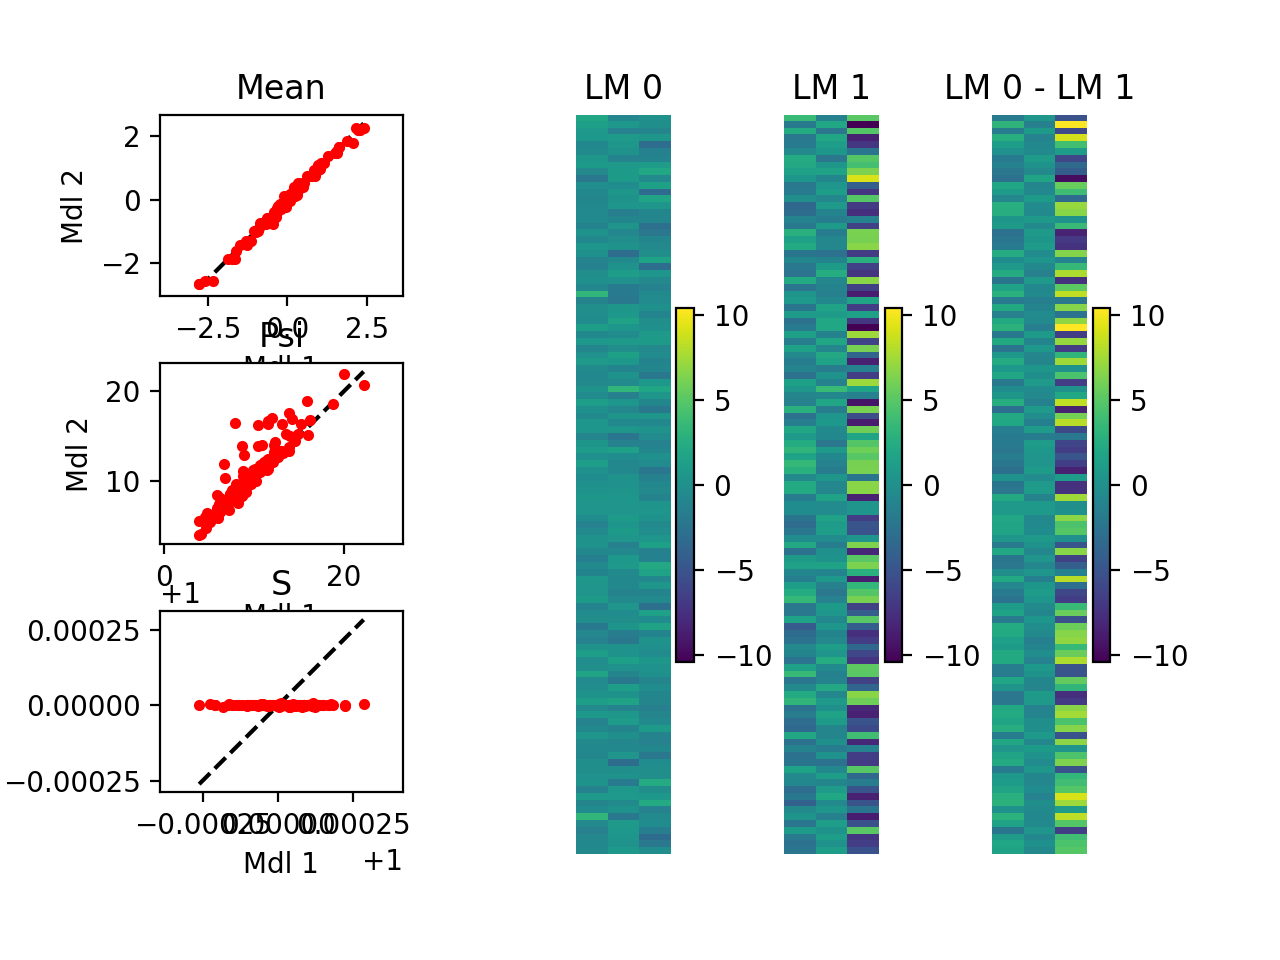

In [19]:
fit_lm = sp_vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = sp_vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = sp_vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
fit_s = sp_vi_collections[exam_mdl].posteriors.s_post(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = GNLDRMdl(n_latent_vars=n_latent_vars, 
                   m=sp_m_fit, lm=fit_lm, mn=fit_mn, psi=fit_psi, s=fit_s)
true_mdl = ind_true_mdls[exam_mdl]

plt.figure()
true_mdl.compare_models(true_mdl, cmp_mdl)

## Setup everything for fitting models with individual posteriors

In [20]:
ip_m_fit = copy.deepcopy(sp_m_fit)

In [21]:
ip_priors = copy.deepcopy(sp_priors)

ip_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, n_smps=ind_n_smps, n_latent_vars=n_latent_vars, 
                                          n_intermediate_latent_vars=n_intermediate_latent_vars,
                                          s_opts={'mn_mn': s_mn, 'mn_std': .00000001, 'std_iv': .01})

In [22]:
for s_i, posteriors in enumerate(ip_posteriors):
    
    # Initialize the poseteriors for the mean vectors
    with torch.no_grad():
        mn_prior_mn = sp_priors.mn_prior(ind_props[s_i]).squeeze()
        mn_prior_std = sp_priors.mn_prior.std_f(ind_props[s_i]).squeeze()
    
        posteriors.mn_post.dists[0].mn_f.f.vl.data = copy.deepcopy(mn_prior_mn)
        posteriors.mn_post.dists[0].std_f.f.set_value(copy.deepcopy(mn_prior_std.numpy()))
        
    # Initialize the posteriors for the loading matrices
    with torch.no_grad():
          
        for d_i in range(n_latent_vars):
            cur_mn = sp_priors.lm_prior.dists[d_i](ind_props[s_i]).squeeze()
            cur_std = sp_priors.lm_prior.dists[d_i].std_f(ind_props[s_i]).squeeze().numpy()
            
            posteriors.lm_post.dists[d_i].mn_f.f.vl.data = copy.deepcopy(cur_mn)
            posteriors.lm_post.dists[d_i].std_f.f.set_value(copy.deepcopy(cur_std))
        
    # Initialize the posteriors for the private variances
    posteriors.psi_post = copy.deepcopy(sp_posteriors[s_i].psi_post)
    
    # Initialize the posteriors for the scales
    #posteriors.s_post = copy.deepcopy(sp_posteriors[s_i].s_post)
    
    # Initialize the posteriors for the latents
    with torch.no_grad():
        posteriors.latent_post = copy.deepcopy(sp_posteriors[s_i].latent_post)

In [23]:
ip_fit_mdls = [GNLDRMdl(n_latent_vars=n_latent_vars, m=ip_m_fit, lm=None, mn=None, psi=None, s=None) 
               for i in range(n_individuals)]
                    
                    
                   
ip_vi_collections = [VICollection(data=ind_data[s_i][1], 
                                  props=ind_props[s_i],
                                  mdl = ip_fit_mdls[s_i],
                                  posteriors = ip_posteriors[s_i]) for s_i in range(n_individuals)]

## Fit ip model

In [24]:
ip_fitter = Fitter(vi_collections=ip_vi_collections, priors=ip_priors, devices=devices)

In [25]:
ip_fitter.distribute(distribute_data=True, devices=devices)
ip_logs = [ip_fitter.fit(1000, milestones=[100, 500], update_int=100, init_lr=.1) for fit_r in range(1)]


=========== EPOCH 0 COMPLETE ===========
Obj: 1.66e+08
----------------------------------------
NELL: 3.36e+06, 4.10e+06, 4.10e+06, 4.50e+06, 4.33e+06
Latent KL: 1.30e+04, 1.67e+04, 1.80e+04, 1.70e+04, 1.71e+04
LM KL: 6.34e+04, 7.66e+04, 1.29e+05, 7.90e+04, 1.20e+05
Mn KL: 1.33e+02, 1.84e+02, 1.35e+02, 1.40e+02, 1.60e+02
Psi KL: 8.71e+01, 1.17e+02, 6.94e+01, 9.31e+01, 1.02e+02
S KL: 2.77e+07, 2.95e+07, 2.80e+07, 2.92e+07, 3.05e+07
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.3100259304046631
----------------------------------------
CPU cur memory used (GB): 3.83e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 1.96e+07
----------------------------------------
NELL: 3.22e+06, 3.91e+06, 3.86e+06, 4.26e+06, 4.11e+06
Latent KL: 3.27e+04, 3.78e+04, 4.39e+04, 4.36e+04, 4.09e+04
LM KL: 4.01e+02, 4.23e+02, 4.12e+02, 4.41e+02, 4.39e+02
Mn KL: 1.53e+02, 1.71e+02, 1.82e+02, 1.74e+02, 1.73e+02
Psi KL: 4.54e+01, 5.66e+01, 4.15e+01, 4.69e+01, 4.99e+01
S KL: 4.51e+02, 

## Look at aligned ip model fits

In [26]:
exam_mdl = 0

<IPython.core.display.Javascript object>


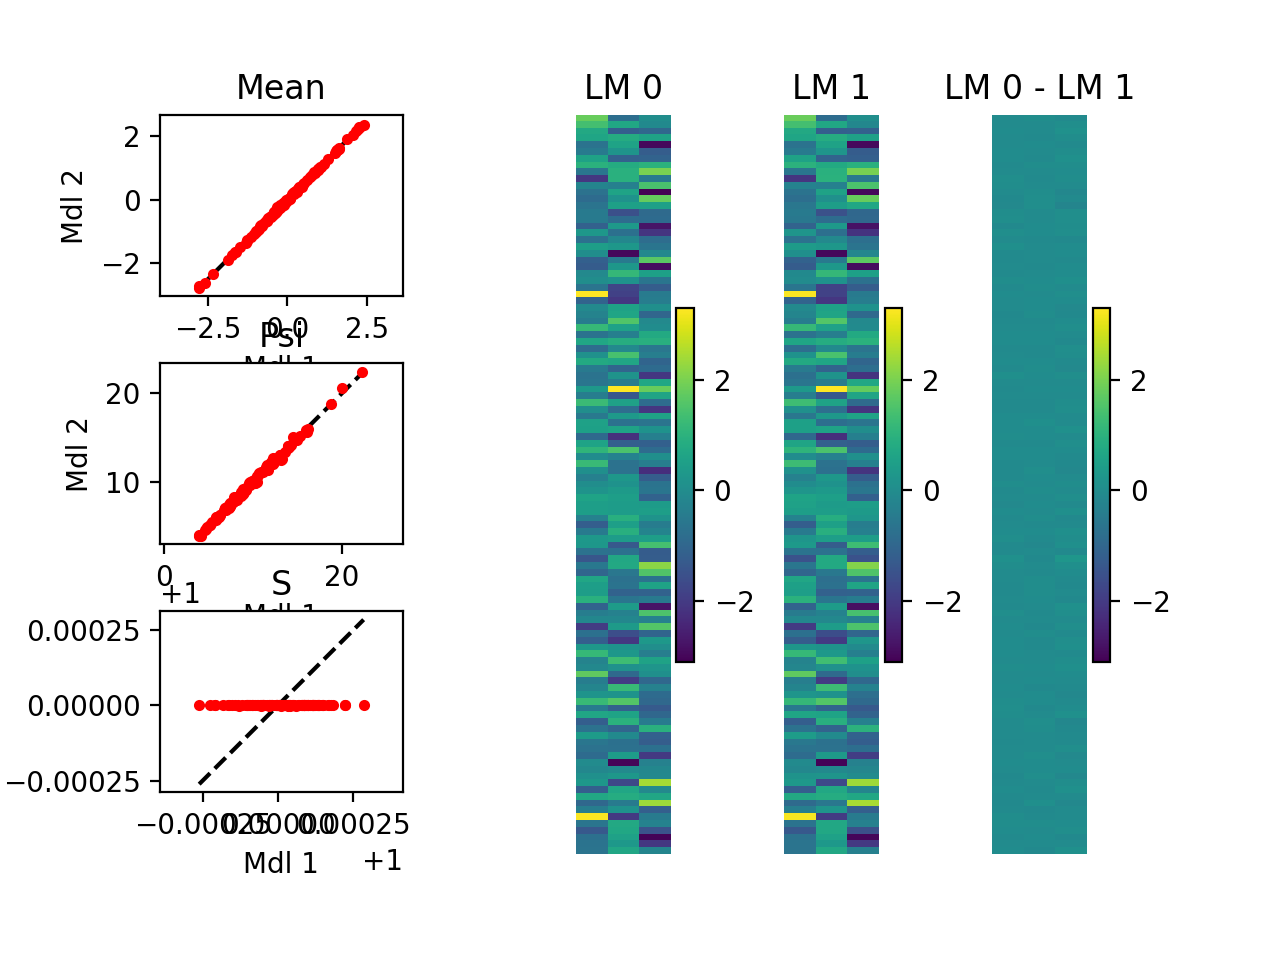

In [27]:
fit_lm = ip_vi_collections[exam_mdl].posteriors.lm_post(ind_props[exam_mdl]).detach().squeeze()
fit_mn = ip_vi_collections[exam_mdl].posteriors.mn_post(ind_props[exam_mdl]).detach().squeeze()
fit_psi = ip_vi_collections[exam_mdl].posteriors.psi_post.mode(ind_props[exam_mdl]).detach().squeeze()
fit_s = ip_vi_collections[exam_mdl].posteriors.s_post(ind_props[exam_mdl]).detach().squeeze()

cmp_mdl = GNLDRMdl(n_latent_vars=n_latent_vars, m=Identity(), lm=fit_lm, mn=fit_mn, psi=fit_psi, s=fit_s)

plt.figure()
true_mdl.compare_models(ind_true_mdls[exam_mdl], cmp_mdl)

## Look at true and estimated intermediate latents

In [28]:
intermediate_z_true = m_true(ind_data[exam_mdl][0]).detach().numpy()
intermediate_z_fit = ip_m_fit(ip_posteriors[exam_mdl].latent_post.mns).detach().numpy()

In [29]:
aligned_mn, aligned_lm, w, aligned_intermediate_z = align_intermediate_spaces(lm0=ind_true_mdls[exam_mdl].lm.detach().numpy(), 
                          mn0=ind_true_mdls[exam_mdl].mn.detach().numpy(),
                          s0=ind_true_mdls[exam_mdl].s.detach().numpy(),
                          lm1=fit_lm.detach().numpy(), 
                          mn1=fit_mn.detach().numpy(),
                          s1=fit_s.detach().numpy(), 
                          int_z0=intermediate_z_true, 
                          int_z1=intermediate_z_fit, 
                          align_by_params=False)

<IPython.core.display.Javascript object>


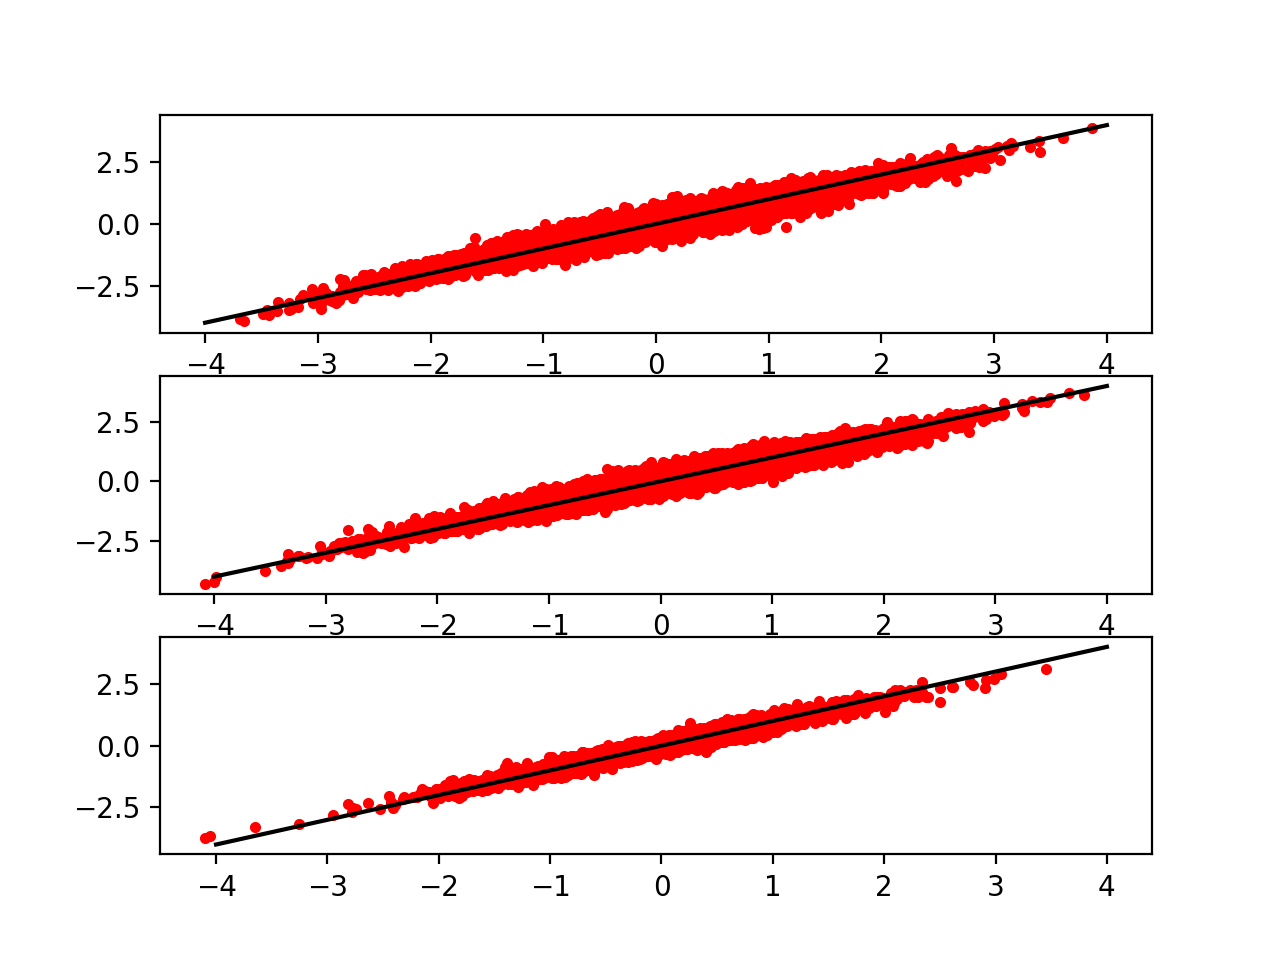

In [30]:
plt.figure()
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(intermediate_z_true[:, i], aligned_intermediate_z[:, i], 'r.')
    plt.plot([-4, 4], [-4, 4], 'k-')

In [31]:
clrs = assign_colors_to_pts(ind_data[exam_mdl][0], lims=np.asarray([[-2, 2], [-2, 2]]))

<IPython.core.display.Javascript object>


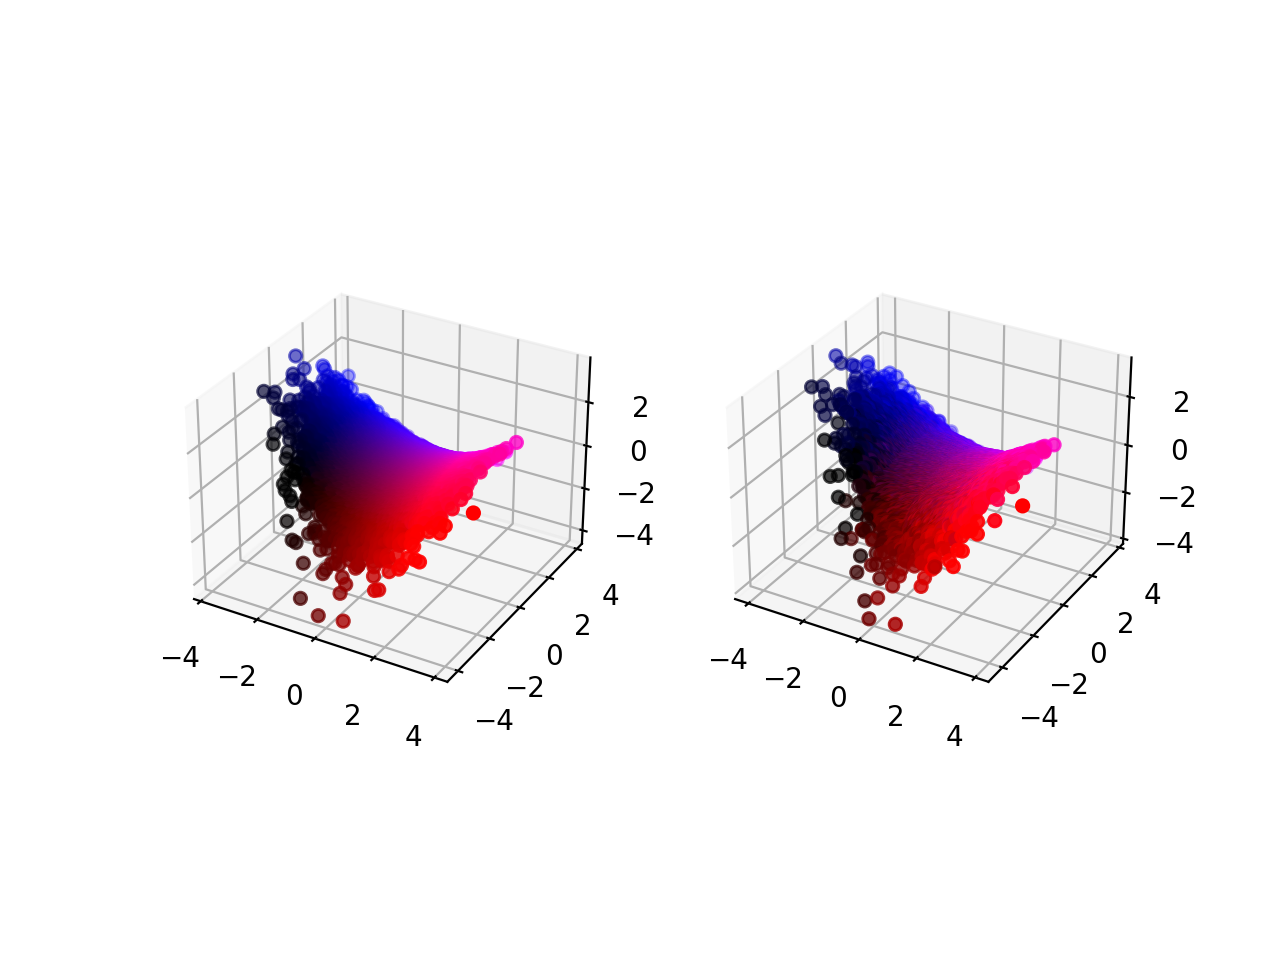

<Axes3DSubplot:>

In [32]:
plt.figure()
a = plt.subplot(1,2,1, projection='3d')
plot_three_dim_pts(intermediate_z_true, clrs=clrs, a=a)

a = plt.subplot(1,2,2, projection='3d')
plot_three_dim_pts(aligned_intermediate_z, clrs=clrs, a=a)

## View latents in low-d space

In [35]:
orig_z = ind_data[exam_mdl][0].numpy()
fit_z = ip_posteriors[exam_mdl].latent_post.mns.detach().numpy()

In [36]:
clrs = assign_colors_to_pts(orig_z, lims=np.asarray([[-2, 2], [-2, 2]]))

<IPython.core.display.Javascript object>


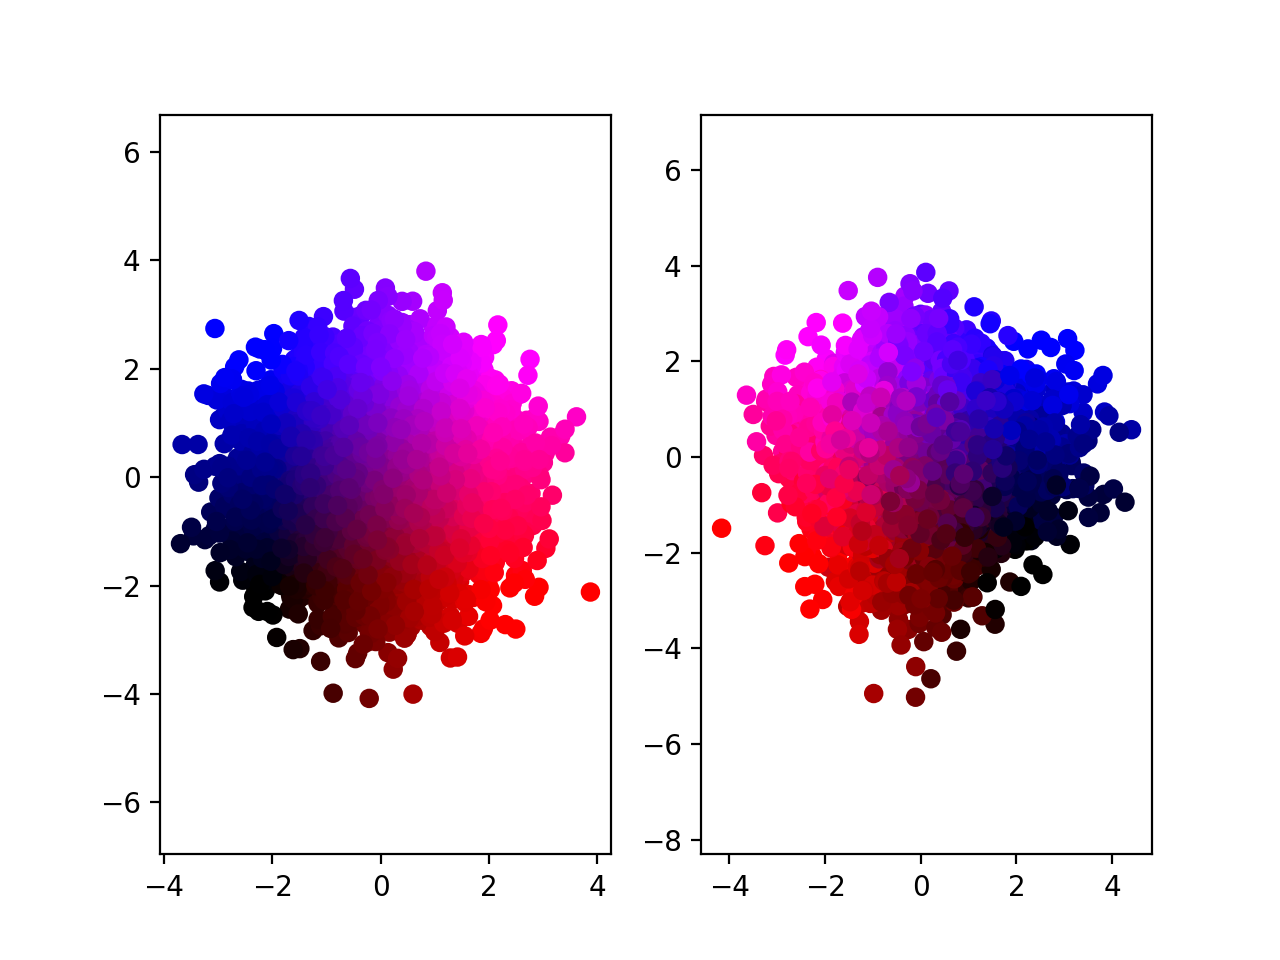

(-4.59317638874054, 4.83298876285553, -5.464651393890381, 4.305059719085693)

In [144]:
plt.figure()
ax = plt.subplot(1,2,1)
plt.scatter(orig_z[:,0], orig_z[:,1], c=clrs)
ax.axis('equal')

ax = plt.subplot(1,2,2)
plt.scatter(fit_z[:,0], fit_z[:,1], c=clrs)
ax.axis('equal')


## Examine true and fit distributions

<IPython.core.display.Javascript object>


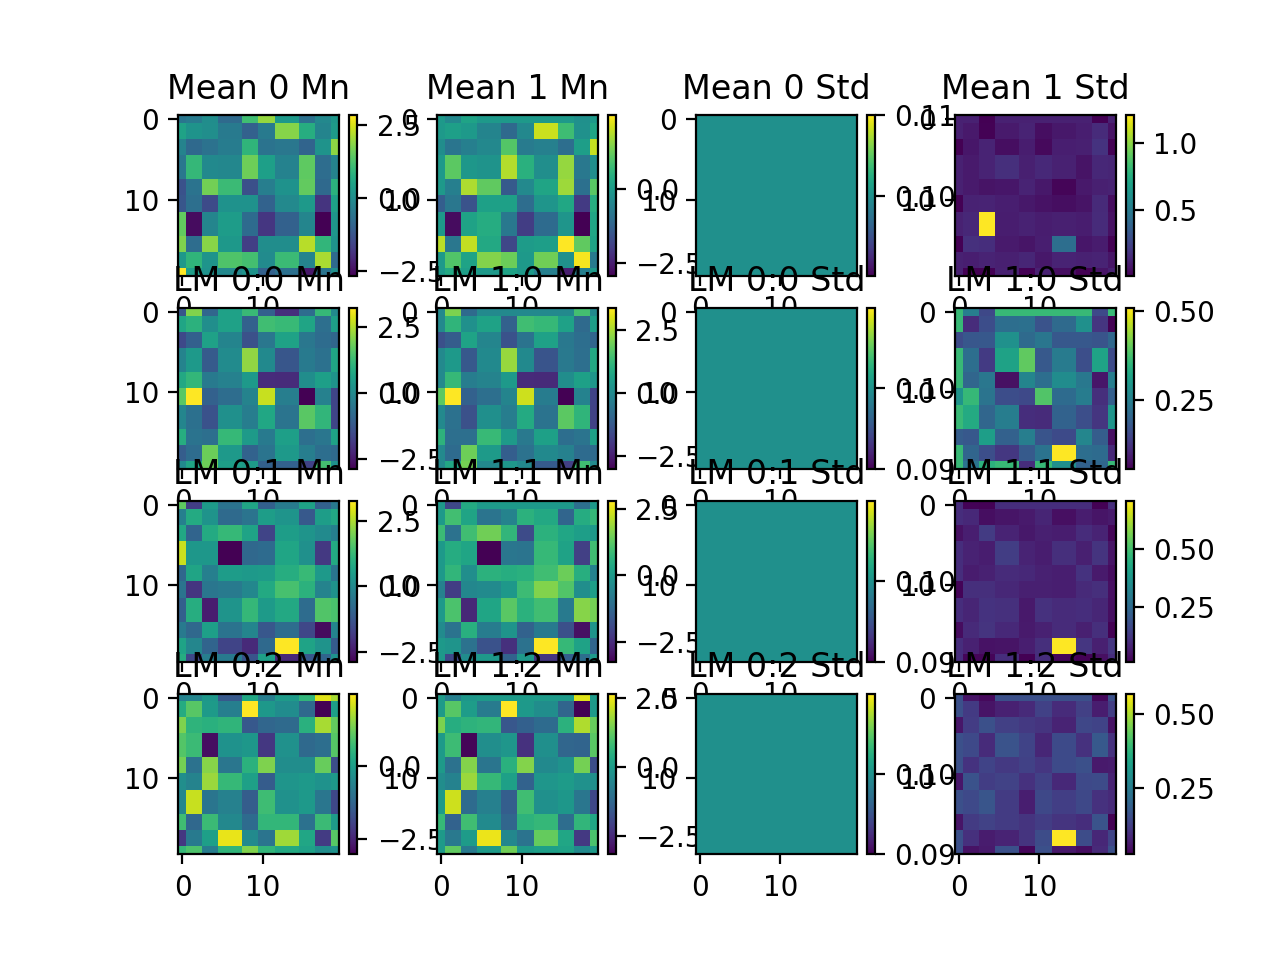

In [140]:
compare_mean_and_lm_dists(lm_0_prior=true_priors.lm_prior, mn_0_prior = true_priors.mn_prior,
                          s_0_prior = true_priors.s_prior, lm_1_prior = ip_priors.lm_prior,
                          mn_1_prior = ip_priors.mn_prior, s_1_prior = ip_priors.s_prior, 
                          dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[20, 20])

### Visualize parameters of the true prior distribution over private variances

<IPython.core.display.Javascript object>


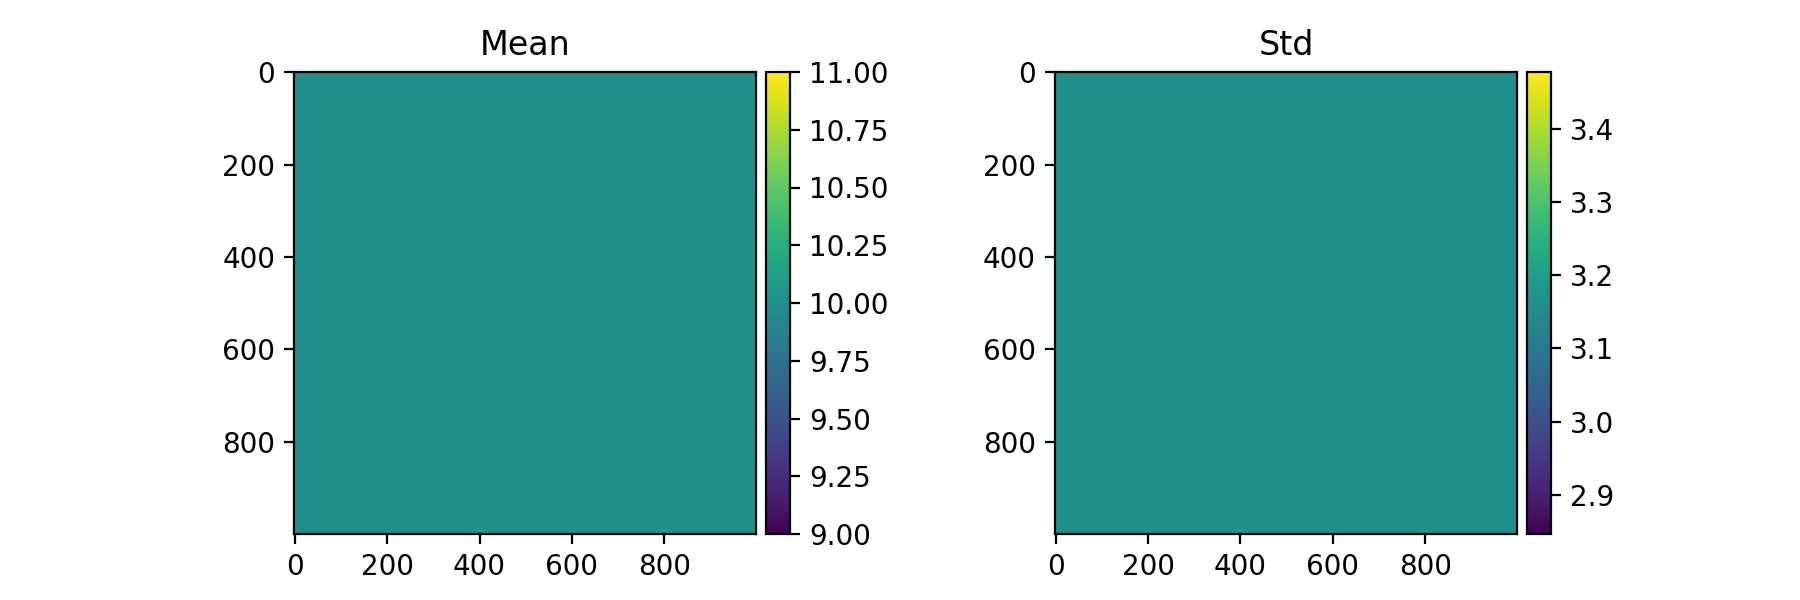

In [41]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=true_priors.psi_prior.forward, std_f=true_priors.psi_prior.std)

<IPython.core.display.Javascript object>


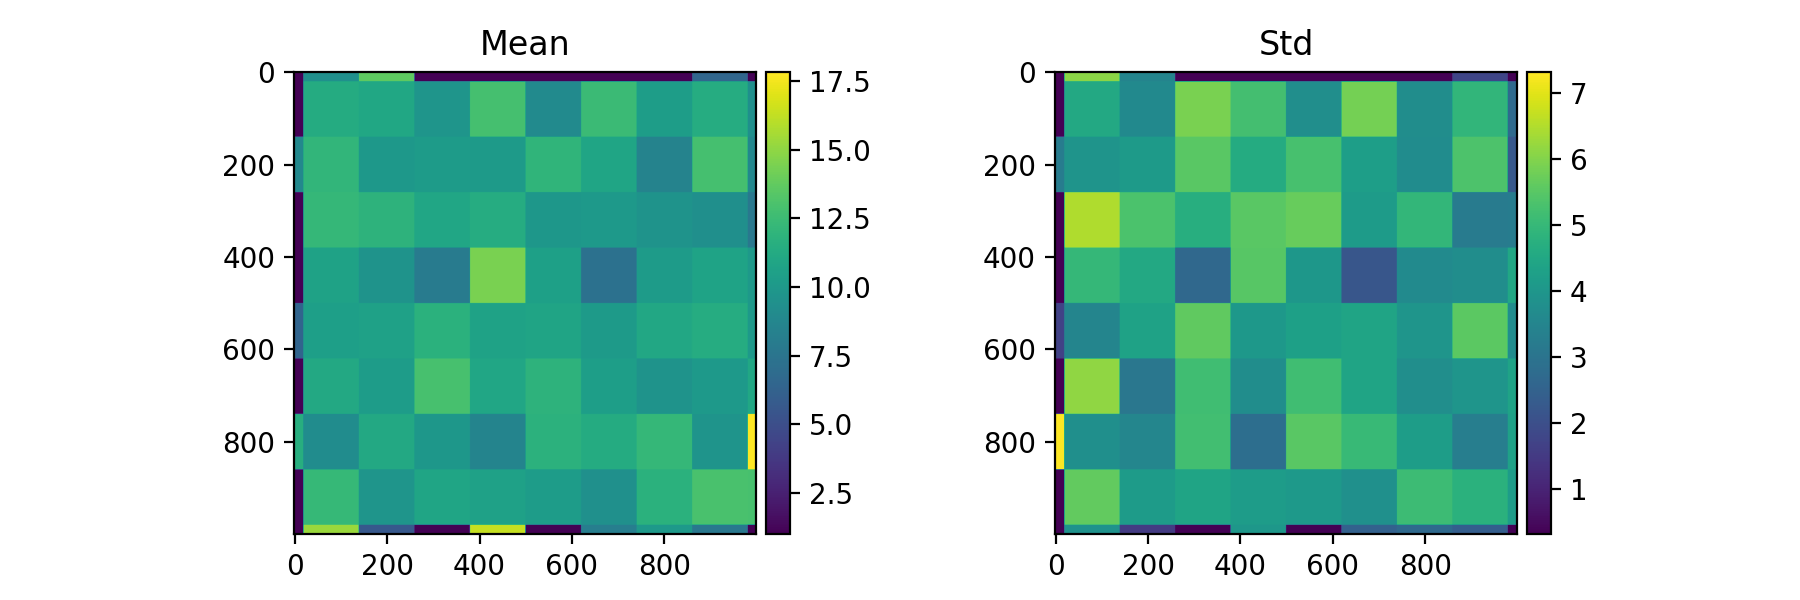

In [42]:
plt.figure(figsize=(9,3))
plot_torch_dist(mn_f=ip_priors.psi_prior.forward, std_f=ip_priors.psi_prior.std)

## Compare means conditioned on latents

<IPython.core.display.Javascript object>


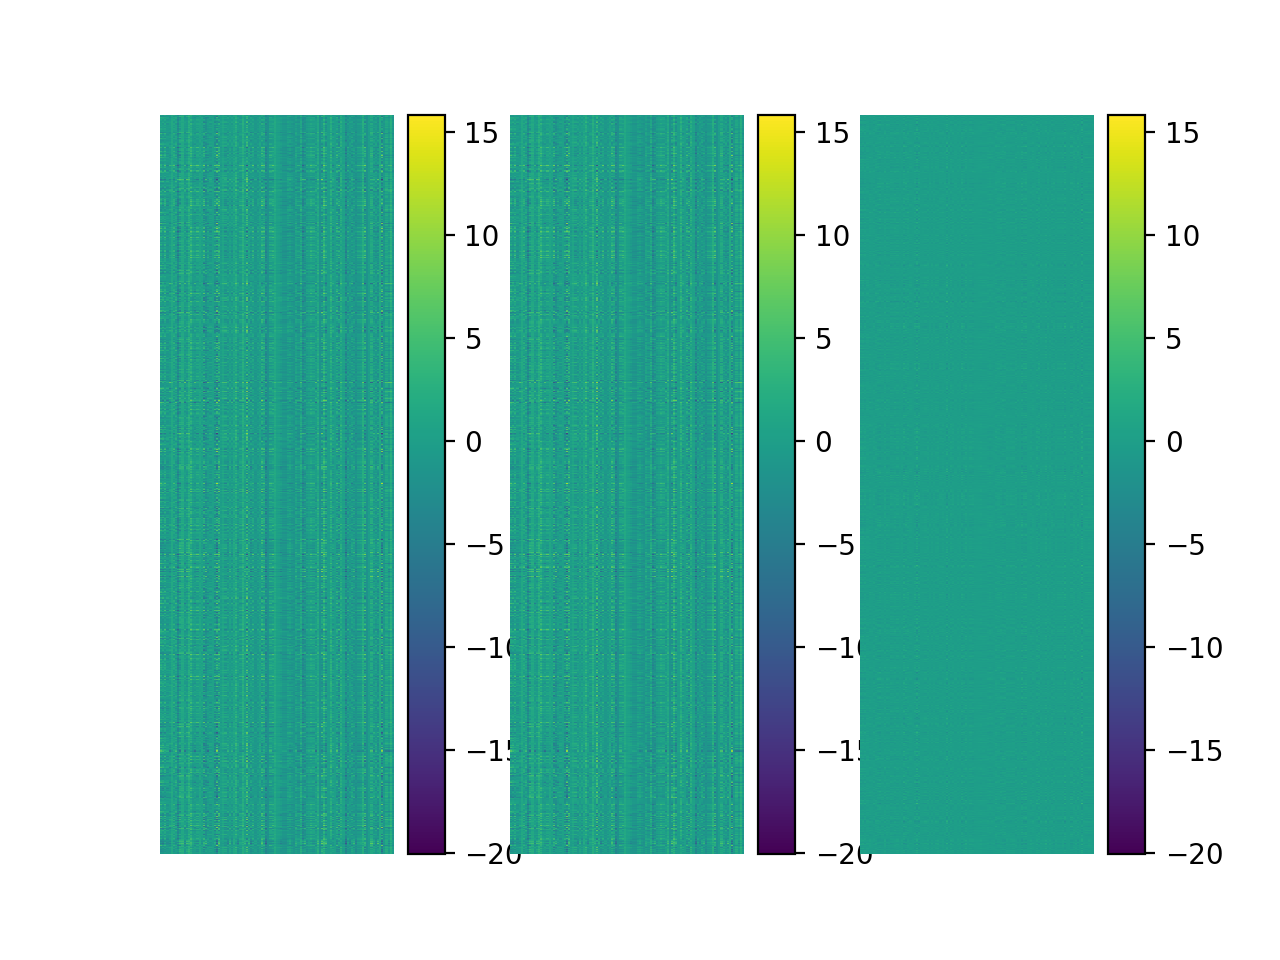

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [141]:
true_mns = ind_true_mdls[exam_mdl].cond_mean(ind_data[exam_mdl][0]).detach().numpy()
fit_mns = ip_vi_collections[exam_mdl].mdl.cond_mean(z=ip_posteriors[exam_mdl].latent_post.mns, 
                                                    lm=fit_lm, 
                                                    mn=fit_mn, 
                                                    s=fit_s, 
                                                    psi=fit_psi).detach().numpy()

plt.figure()
cmp_n_mats([true_mns, fit_mns, fit_mns-true_mns], show_colorbars=True)
#cmp_n_mats([ind_data[exam_mdl][1].numpy(), fit_mns, fit_mns-ind_data[exam_mdl][1].numpy()], show_colorbars=True)